In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Import dataset
df = pd.read_csv('Resources/Most Streamed Spotify Songs 2024.csv', encoding='latin1')
# Drop columns that will not be used
df = df.drop(columns=['All Time Rank','Release Date','Track', 'Album Name', 'Artist', 'ISRC','TIDAL Popularity'])
df.head()

,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,TikTok Posts,TikTok Likes,TikTok Views,...,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,Explicit Track
0,725.4,"390,470,936","30,716","196,631,588",92.0,"84,274,754","1,713,126","5,767,700","651,565,900","5,332,281,936",...,"40,975",684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",0
1,545.9,"323,703,884","28,113","174,597,137",92.0,"116,347,040","3,486,739","674,700","35,223,547","208,339,025",...,"40,778",3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",1
2,538.4,"601,309,283","54,331","211,607,669",92.0,"122,599,116","2,228,730","3,025,400","275,154,237","3,369,120,610",...,"74,333",536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",0
3,444.9,"2,031,280,633","269,802","136,569,078",85.0,"1,096,100,899","10,629,796","7,189,811","1,078,757,968","14,603,725,994",...,"1,474,799","2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",0
4,423.3,"107,034,922","7,223","151,469,874",88.0,"77,373,957","3,670,188","16,400",NaN,NaN,...,"12,185",1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",1


In [3]:
# Convert data type into numbers
df = df.apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce') if x.dtype == 'object' else x)

In [4]:
# Check corrleations with target
df.corr()['Spotify Streams']

Track Score                   0.251246
Spotify Streams               1.000000
Spotify Playlist Count        0.815083
Spotify Playlist Reach        0.589893
Spotify Popularity            0.359931
YouTube Views                 0.468619
YouTube Likes                 0.561698
TikTok Posts                  0.026984
TikTok Likes                  0.043871
TikTok Views                  0.030481
YouTube Playlist Reach        0.273238
Apple Music Playlist Count    0.744907
AirPlay Spins                 0.441739
SiriusXM Spins                0.130077
Deezer Playlist Count         0.644825
Deezer Playlist Reach         0.040043
Amazon Playlist Count         0.455191
Pandora Streams               0.617322
Pandora Track Stations        0.418241
Soundcloud Streams            0.342311
Shazam Counts                 0.734642
Explicit Track               -0.002875
Name: Spotify Streams, dtype: float64

In [5]:
# Only select columns with enough correlation with target
correlations = df.corr()['Spotify Streams']
selected_cols = correlations[abs(correlations) > 0.2].index
df_clean = df[selected_cols]
df_clean = df_clean[['Spotify Streams'] + [col for col in selected_cols if col != 'Spotify Streams']]
df_clean = df_clean.dropna()
df_clean.head()

,Spotify Streams,Track Score,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,YouTube Playlist Reach,Apple Music Playlist Count,AirPlay Spins,Deezer Playlist Count,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts
0,390470936.0,725.4,30716.0,196631588.0,92.0,84274754.0,1713126.0,1.505970e+08,210.0,40975.0,62.0,114.0,18004655.0,22931.0,4818457.0,2669262.0
1,323703884.0,545.9,28113.0,174597137.0,92.0,116347040.0,3486739.0,1.563804e+08,188.0,40778.0,67.0,111.0,7780028.0,28444.0,6623075.0,1118279.0
2,601309283.0,538.4,54331.0,211607669.0,92.0,122599116.0,2228730.0,3.737850e+08,190.0,74333.0,136.0,172.0,5022621.0,5639.0,7208651.0,5285340.0
4,107034922.0,423.3,7223.0,151469874.0,88.0,77373957.0,3670188.0,1.127639e+08,182.0,12185.0,82.0,105.0,4493884.0,7006.0,207179.0,457017.0
5,670665438.0,410.1,105892.0,175421034.0,83.0,131148091.0,1392593.0,2.867223e+09,138.0,522042.0,86.0,152.0,138529362.0,50982.0,9438601.0,4517131.0


In [6]:
# Set target as Track Score
X = df_clean.drop(columns=['Spotify Streams'])
y = df_clean['Spotify Streams']

In [7]:
# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Scale data with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest Regression

In [8]:
# Create Random Forest Regression model and fit data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [9]:
# Use Random Forest model to predict
rf_preds = rf_model.predict(X_test_scaled)
# Check R2 score and MSE
rf_r2 = r2_score(y_test, rf_preds)
rf_mse = mean_squared_error(y_test, rf_preds)

print(f"R2 score = {rf_r2}")
print(f"MSE = {rf_mse}")

R2 score = 0.84934233472019
MSE = 5.140342600222518e+16


### Ridge Regression

In [10]:
# Create Ridge model and fit data
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [11]:
# Use Ridge model to predict
ridge_preds = ridge_model.predict(X_test_scaled)
# Check R2 score and MSE
ridge_r2 = r2_score(y_test, ridge_preds)
ridge_mse = mean_squared_error(y_test, ridge_preds)

print(f"R2 score = {ridge_r2}")
print(f"MSE = {ridge_mse}")

R2 score = 0.840584304339933
MSE = 5.439160961532351e+16


### Linear Regression

In [12]:
# Create Linear Regression model and fit data
lg_model = LinearRegression()
lg_model.fit(X_train_scaled, y_train)

LinearRegression()

In [13]:
# Use Linear Regression model to predict
lg_preds = lg_model.predict(X_test_scaled)
# Check R2 score and MSE
lg_r2 = r2_score(y_test, lg_preds)
lg_mse = mean_squared_error(y_test, lg_preds)

print(f"R2 score = {lg_r2}")
print(f"MSE = {lg_mse}")

R2 score = 0.840354338161878
MSE = 5.4470072595582184e+16


### K-Nearest Neighbors Regression

In [14]:
# Create KNN model and fit data
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [15]:
# Use KNN model to predict
knn_preds = knn_model.predict(X_test_scaled)
# Check R2 score and MSE
knn_r2 = r2_score(y_test, knn_preds)
knn_mse = mean_squared_error(y_test, knn_preds)

print(f"R2 score = {knn_r2}")
print(f"MSE = {knn_mse}")

R2 score = 0.8006480383660597
MSE = 6.801760659981478e+16


### Random Forest Regression has the highest R2 score of 0.849.

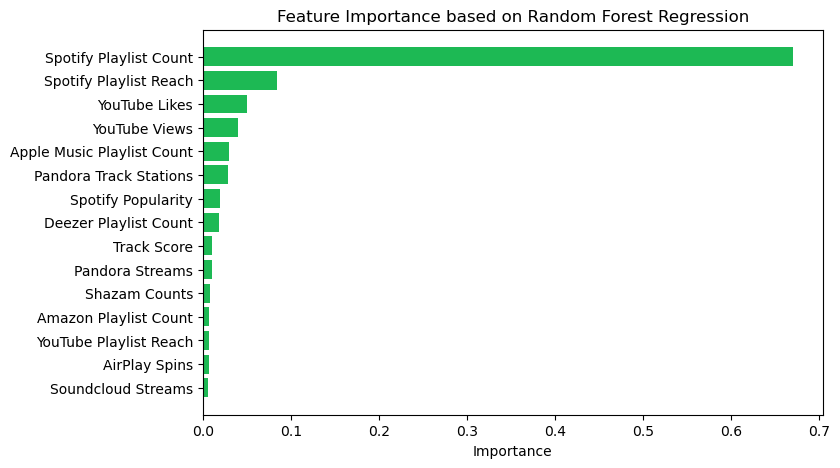

In [16]:
df_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
df_importance = df_importance.sort_values(by='importance')

plt.figure(figsize=(8,5))
plt.barh(df_importance['feature'], df_importance['importance'], color='#1DB954')
plt.xlabel('Importance')
plt.title('Feature Importance based on Random Forest Regression')
plt.show()

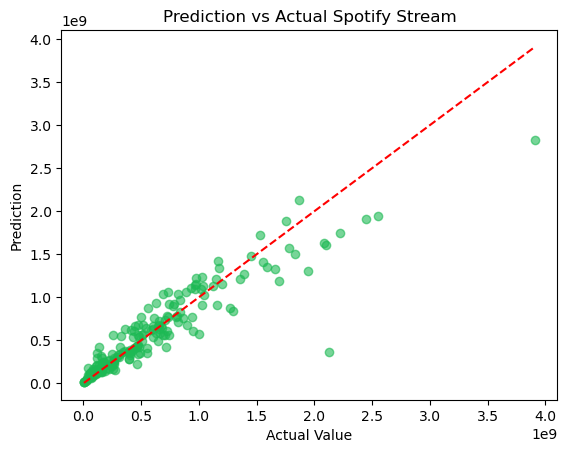

In [17]:
y_range = [y_test.min(), y_test.max()]
plt.scatter(y_test, rf_preds, alpha=0.6, color='#1DB954')
plt.plot(y_range, y_range, color='red', linestyle='--')
plt.xlabel("Actual Value")
plt.ylabel("Prediction")
plt.title("Prediction vs Actual Spotify Stream")
plt.show()